# Single Cell Analysis Tutorial

Samuele Soraggi
[](https://orcid.org/0000-0002-1159-5535)

This tutorial will give you the extensive basic commands and
explanations for the single cell analysis of your own dataset.

-   The **first part of the tutorial** ([Section 2](#sec-preprocessing))
    is focused on **preprocessing** the data, which means primarily
    filtering and normalizing it.

-   The **second part of the tutorial** ([Section 3](#sec-integration))
    is focused on **integrating** all sixteen datasets produced from the
    lab sessions (you will perform this integration analysis in groups),
    identifying cell types and find a population of cells expressing the
    HAR1 gene to analyze different conditions of mutant VS wild type
    Lotus japonicus.

-   The **third part of the tutorial** ([Section 4](#sec-geneanalysis))
    applies tipycal gene analysis to detect genes conserved and
    differentially expressed between conditions

-   The **fourth part of the tutorial** ([Section 4.2](#sec-networks))
    pivots around the study of groups of genes co-expressed in the data
    and in specific clusters and conditions

The first two parts follow the phylosophy of the best practices
explained in Luecken and Theis (2019) and Heumos et al. (2023). The
third part applies standard statistical tests on the average gene
expressions in subsets of the data. The last part is based pulling cells
transcripts together with different granularities to improve the
statistical power of calculations based on their gene expression (as in
Morabito et al. (2023)).

The tutorial is based on four samples of Lotus Japonicus (two
rhizobia-infected and two wild types) from [Frank et al.
(2023)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10630511/pdf/41467_2023_Article_42911.pdf).
The last section follows some of the [tutorials from
hdWGCNA](https://smorabit.github.io/hdWGCNA/).

> **Learning outcomes**
>
> At the end of this tutorial **you will be able to use `R` to**
>
> -   **Filter** your data selecting specific criteria
> -   **Preprocess** your data for advanced analysis
> -   **Merge and integrate** datasets and perform **cross-data
>     analysis**
> -   **Identify potential cell types** by markers and exploiting other
>     datasets
> -   Perform and elaborate **differential and conserved** gene
>     expression
> -   Infer **gene modules** from your data and isolate significant ones
>     related to a cell type
> -   **Visualize gene modules** and extract their **gene ontology** to
>     draw biological conclusions

## A (rather very) short biological background

Lotus Japonicus is a legume characterized by the legume-rhizobium
symbiotic interaction (rhizobia are soil microorganisms that can
interact with leguminous plants to form root nodules within which
conditions are favourable for bacterial nitrogen fixation. Legumes allow
the development of very large rhizobial populations in the vicinity of
their roots). [Figure 1](#fig-nitrogenfixing) and text below it from
Wang, Liu, and Zhu (2018).

![Figure 1: Symbiosis signaling and plant immunity involved in
recognition specificity in the legume-rhizobial interactions (indicated
by the red stars). **A** The process of infection and nodule
development. A mature indeterminate nodule contains a meristem zone (I),
an infection zone (II), an interzone (IZ), a nitrogen fixing zone (III),
and a senescent zone (IV). **B** The host secretes flavonoids to induce
the expression of bacterial nodulation (nod) gene through the activation
of NodD proteins. The enzymes encoded by the nod genes lead to the
synthesis of Nod factors (NF) that are recognized by host Nod factor
receptors (NFRs). Recognition specificity occurs both between Flavonoids
and NodDs and between NF and NFRs. **C** In addition to NF signaling,
bacteria also produce extracellular polysaccharides (EPS) and type III
effectors to facilitate their infection in compatible interactions, but
these molecules may also induce immune responses causing resistance to
infection in incompatible interactions. **D** Certain legumes such as
Medicago encode antimicrobial nodule-specific cysteine-rich (NCR)
peptides to drive their bacterial partners to terminal differentiation
that is required for nitrogen fixation. However, some rhizobial strains
cannot survive the antibacterial activity of certain peptide isoforms,
leading to formation of nodules defective in nitrogen
fixation.](attachment:images/nitrogenfixing.jpg)

Rhizobial invasion of legumes is primarily mediated by a plant-made
tubular invagination called an infection thread (IT). Research has shown
that various genes are involved in some of the processes of the
legume-rhizobia interaction. [Figure 2](#fig-ljinfection) and text below
it from Szczyglowski et al. (1998).

![Figure 2: Primary infection of Lotus japonicus roots inoculated with
Mesorhizobium loti strain NZP2235. **A**, Brightfield micrograph of root
hair curlings resembling shepherd’s-crook structures (arrows). **B–C**,
Phase contrast micrographs of the intracellular infection threads within
curled root hairs. Arrows point to infection threads with papilla-like
structures on their outer surface. Bar, 70 µm **A**, 25 µm **B**, and 20
µm **C**.](attachment:images/LJinfection.png)

-   **RINRK1** (Rhizobial Infection Receptor-like Kinase1), that is
    induced by Nod factors (NFs) and is involved in IT formation but not
    nodule organogenesis. A paralog, RINRK2, plays a relatively minor
    role in infection. RINRK1 is required for full induction of early
    infection genes, including Nodule Inception (NIN), encoding an
    essential nodulation transcription factor. See Li et al. (2019).
-   **HAR1** mediates nitrate inhibition and autoregulation of
    nodulation. Autoregulation of nodulation involves
    root-to-shoot-to-root long-distance communication, and HAR1
    functions in shoots. HAR1 is critical for the inhibition of
    nodulation at 10 mM nitrate. The nitrate-induced CLE-RS2
    glycopeptide binds directly to the HAR1 receptor, this result
    suggests that CLE-RS2/HAR1 long-distance signaling plays an
    important role in the both nitrate inhibition and the autoregulation
    of nodulation. See Okamoto and Kawaguchi (2015).
-   **SYMRKL1**, encodes a protein with an ectodomain predicted to be
    nearly identical to that of SYMRK and is required for normal
    infection thread formation. See Frank et al. (2023).

# UMI-based single cell data from microdroplets

The dataset is based on a **microdroplet-based method from 10X
chromium**. We remember that a microdroplet single cell sequencing
protocol works as follow:

-   each cell is isolated together with a barcode bead in a gel/oil
    droplet

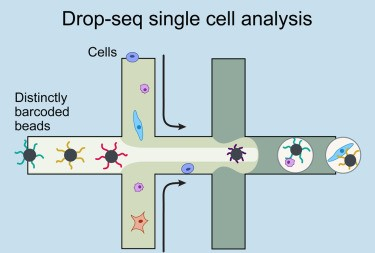

-   each transcript in the cell is captured via the bead and assigned a
    cell barcode and a transcript unique molecular identifier (UMI)
-   3’ reverse transcription of mRNA into cDNA is then performed in
    preparation to the PCR amplification
-   the cDNA is amplified through PCR cycles

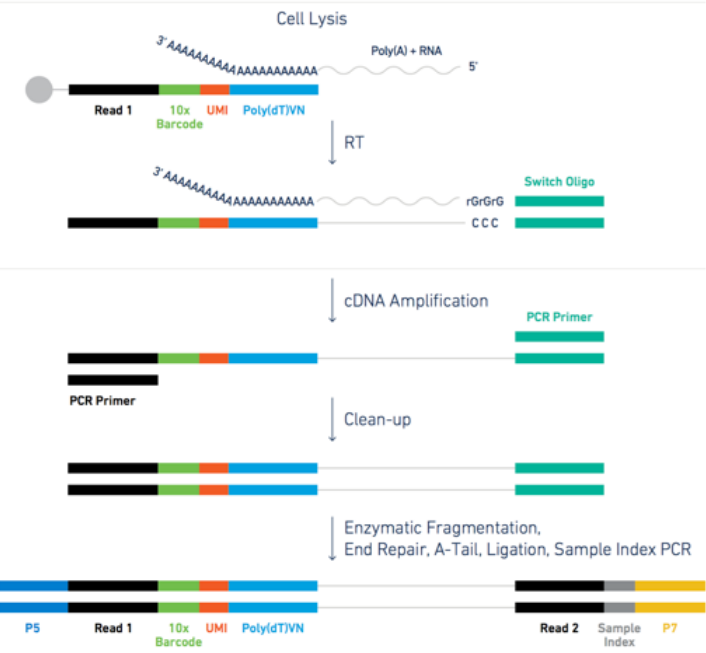

## The raw data in practice

Let’s look at a specific read and its UMI and cell barcode. The data is
organized in paired-end reads (written on `fastq` files), where the
first `fastq` file contains reads in the following format

    @SRR8363305.1 1 length=26
    NTGAAGTGTTAAGACAAGCGTGAACT
    +SRR8363305.1 1 length=26
    #AAFFJJJJJJJJJJJJJJJJFJJJJ

Here, the first 16 characters `NTGAAGTGTTAAGACA` represent the cell
barcode, while the last 10 characters `AGCGTGAACT` are the transcript
UMI tag. The last line represents the quality scores of the 26
characters of barcode+UMI.

The associated second `fastq` file contains reads of 98nt as the
following

    @SRR8363305.1 1 length=98
    NCTAAAGATCACACTAAGGCAACTCATGGAGGGGTCTTCAAAGA
        CCTTGCAAGAAGTACTAACTATGGAGTATCGGCTAAGTCAANCN
        TGTATGAGAT
    +SRR8363305.1 1 length=98
    #A<77AFJJFAAAJJJ7-7-<7FJ-7----<77--7FAAA--
        <JFFF-7--7<<-F77---FF---7-7A-777777A-<
        -7---#-#A-7-7--7--

The 98nt-long string of characters in the second line is a partial
sequence of the cDNA transcript. Specifically, the 10X chromium protocol
used for sequencing the data is biased towards the 3’ end, because the
sequencing is oriented from the 3’ to the 5’ end of the transcripts. The
last line contains the corresponding quality scores.

## Alignment and expression matrix

The data is aligned with `cellranger`, a completely automatized
[pipeline implemented by
10X](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger)
for 10X-genomics data.

Apart from the data, the output contains an interactive document
reporting the quality of the data and a small preliminary UMAP plot and
clustering. In this report it is especially instructive to look at the
**knee plot**.

The knee plot is created by plotting the number of unique molecular
identifiers (UMIs) or reads against the number of cells sequenced,
sorted in descending order. The UMIs or reads are a measure of the
amount of RNA captured for each cell, and thus a measure of the quality
of the data. The plot typically shows a **steep slope at the beginning,
followed by a plateau, and then a gradual decrese into a second slope
and a final plateau**.

-   The steep slope represents the initial cells that are of **high
    quality** and have the highest number of UMIs or reads.
-   The first plateau represents the cells that have **lower quality
    data**, and the gradual decrease represents the addition of droplets
    with even lower quality data.
-   Usually, beyond the first slope, you have droplets that are **either
    empty or of so poor quality**, that they are not worth keeping for
    analysis.
-   The height of the last plateau gives you an idea of the **presence
    of ambient RNA** inside droplets. If the last plateau is located
    high up, then the corresponding amount of UMIs consist of background
    ambient RNA which likely pollutes all cells in your data.

Below, the knee plot from the `control 1` sample used in this analysis.
You can see that around 10,000 cells with above ~1000 UMIs seems to be
coinsidered of decent quality by `cellranger` (the part of line coloured
in blue). Note that the last plateau is located at a very low amount of
UMIs, meaning there is not really any relevant contamination from
ambient RNA.

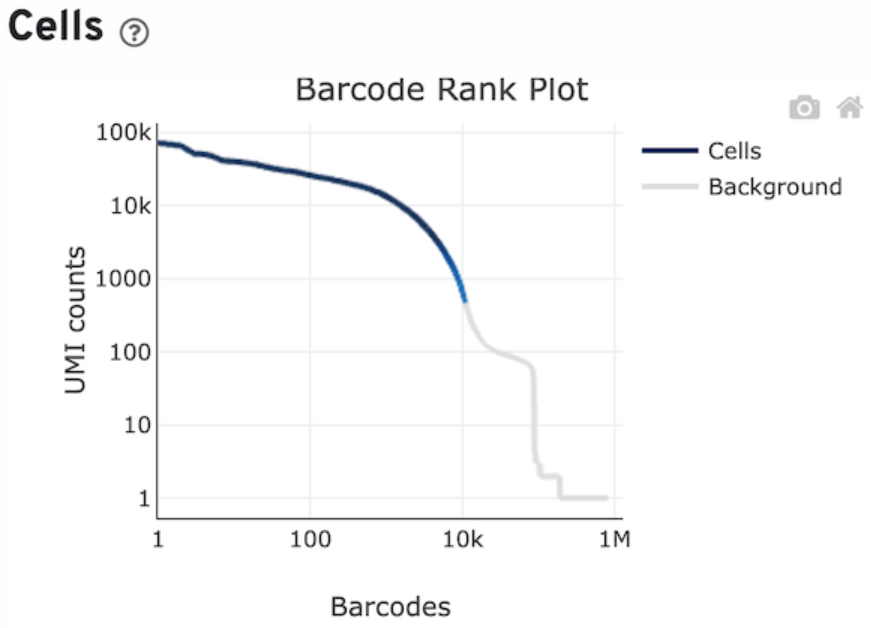

> **Exercise**
>
> In this same folder you have the document `web_summary.html` that
> shows you the quality report of an example dataset produced using the
> `10X cellranger` pipeline for alignment. **Take some time to look at
> it and explore what it contains** (Click on `Trust HTML` on the top
> menu if the html remains blank after opening it). Get an idea of how
> many UMIs there are in cells of decent quality. We will work more on
> filtering out cells based on their quality in this tutorial.
>
> You can read a [technical
> note](https://www.10xgenomics.com/support/single-cell-gene-expression/documentation/steps/sequencing/interpreting-cell-ranger-web-summary-files-for-single-cell-gene-expression-assays)
> on interpreting cellranger reports.

> **Something more about knee plots**
>
> The background RNA (sequenced together with the transcript coming from
> the cell of interest) makes up the *ambient plateau*: the same
> background RNA is contained in empty droplets. If your dataset has
> extremely few UMI counts in empty droplets, then there is not much
> background RNA present - This is the best situation in which you can
> find yourself. See Exhibit A in [Figure 6](#fig-bender).
>
> If you have a dataset where you can identify an *empty droplet
> plateau* by eye (Exhibit B in [Figure 6](#fig-bender)), and these
> empty droplets have 50 or 100 or several hundred counts, then it can
> be advisable to use a specific software to remove the background
> transcripts (e.g. `CellBender` (Fleming et al. (2023)), `SoupX` (Young
> and Behjati (2020))).
>
> If you have a dataset with so much background RNA that you cannot
> identify the *empty droplet plateau* yourself by eye (Exhibit C in
> [Figure 6](#fig-bender)), then any software to remove background
> transcripts will also likely have a difficult time. Such the
> algorithms might be worth a try, but you should **strongly consider
> re-running the experiment, as the knee plot points to a real QC
> failure**
>
> ![Figure 6: Various cases of knee plot you can encounter from
> sequenced data. Figure from [the webpage of
> Cellbender.](https://cellbender.readthedocs.io/)](attachment:images/UMI_curve_tropes.png)

# Preprocessing

> **Learning outcome**
>
> We will answer to the following questions:
>
> -   How can I **import single-cell data** into R?
> -   How are different types of data/information (e.g. cell
>     information, gene information, etc.) **stored and manipulated**?
> -   How can I obtain basic **summary metrics** for cells and genes and
>     **filter the data** accordingly?
> -   How can I **visually explore** these metrics?

We start by loading all the packages necessary for the analysis and
setup a few things
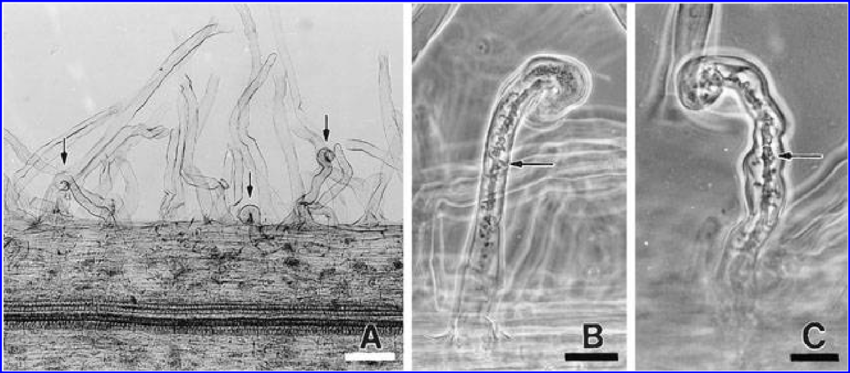
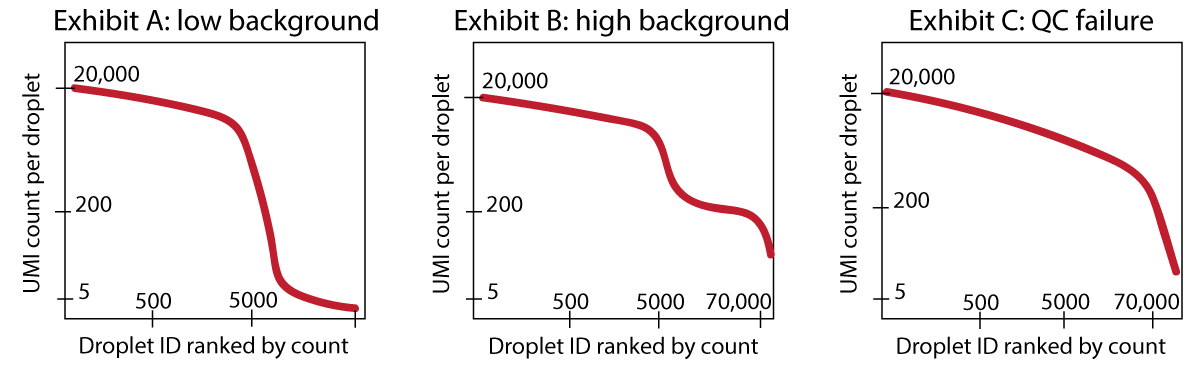
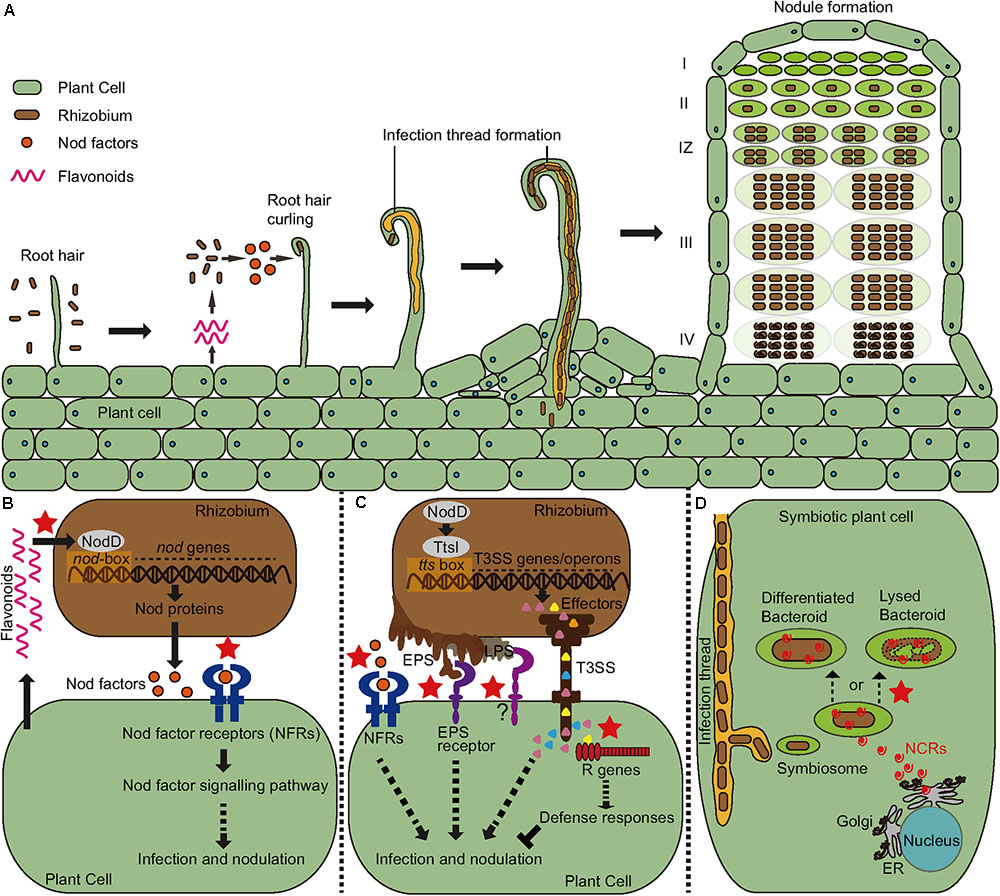

In [ ]:
suppressPackageStartupMessages({
library(SeuratDisk); 
library(Seurat);
library(DoubletFinder);
library(parallel);
library(multtest);
library(metap);
library(purrr);
library(dplyr);
library(stringr);
library(tibble);
library(ggplot2);
library(MAST);
library(WGCNA);
library(hdWGCNA);
library(patchwork);
library(doFuture);})

In [ ]:
source("../Scripts/script.R")

In [ ]:
options(future.seed=TRUE)

In [ ]:
plan("multicore", workers = 8)
options(future.globals.maxSize = 8 * 1024^3)

## Download data

We check if the data exists, otherwise a script will download the
missing data files in the appropriate folder, which should be `../Data`.

In [ ]:
downloadData()

## Import data

We import the data reading the matrix files aligned by 10X. Those are
usually contained in a folder with a name of the type
`aligned_dataset/outs/filtered_bc_matrix`, that 10X Cellranger creates
automatically after the alignment. You need to use such a folder when
your own data is aligned and you need to import it. In this tutorial,
the aligned data is in the folder `../Data/control_1` used below. The
command for reading the data is simply `Read10X`.

In [ ]:
Control1 <- Read10X("../Data/control_1/")

> **Preprocessing multiple datasets**
>
> Note that we are loading only one dataset (`control_1`, one of the two
> control replicates). Another control dataset, and two infected
> datasets, have already been preprocessed and will be used later - so
> **we will now focus on the preprocessing of a single dataset**. In
> general, when you have multiple datasets, you must preprocess them one
> at a time before integrating them together.

What we obtain in the command above is an expression matrix. Look at the
first 10 rows and columns of the matrix (whose rows represent genes and
columns droplets/cells) - the dots are zeros (they are not stored in the
data, which has a compressed format called `dgCMatrix`), and **are the
majority of the expression values obtained in scRNA data!**

In [ ]:
Control1[1:10,1:10]

What is the percentage of zeros in this matrix? You can see it for
yourself below - it is a lot, but quite surprisingly we can get a lot of
information from the data!

In [ ]:
cat("Number of zeros: ")
zeros <-  sum(Control1==0)
cat( zeros )

In [ ]:
cat("Number of expression entries: ")
total <- dim(Control1)[1] * dim(Control1)[2]
cat( total )

In [ ]:
cat("Percentage of zeros: ")
cat( zeros / total * 100 )

## Create a single cell object in Seurat

We use our count matrix to create a Seurat object. A Seurat object
allows you to **store the count matrix** and future modifications of it
(for example its normalized version), together with **information
regarding cells and genes** (such as clusters of cell types) and their
**projections** (such as PCA and tSNE). We will go through these
elements, but first we create the object with `CreateSeuratObject`:

In [ ]:
Control1_seurat <- CreateSeuratObject(counts = Control1, 
                                               project = "Control1_seurat", 
                                               min.cells = 3, 
                                               min.features = 200)

The arguments of the command are \* `counts`: the count matrix \*
`project`: a project name \* `min.cells`: a minimum requirement for
genes, in our case saying they must be expressed in at least 3 cells. If
not, they are filtered out already now when creating the object. \*
`min.features`: a minimum requirement for cells. Cells having less than
200 expressed genes are removed from the beginning from the data.

Values for the minimum requirements chosen above are standard checks
when running the analysis. Droplets not satisfying those requirements
are of extremely bad quality and not worth carrying on during the
analysis (remember the knee plot).

How many genes and cells have been filtered out?

In [ ]:
cat("Starting Genes and Cells:\n")
cat( dim(Control1) )

cat("\nFiltered Genes and Cells:\n")
cat( dim(Control1) - dim(Control1_seurat) )

cat("\nRemaining Genes and Cells:\n")
cat( dim(Control1_seurat) )

We want to use this data later in the analysis with other `Control` and
`Infected` datasets. Therefore we add a `Condition` to the metadata
table, and for this dataset we establish that each cell is `Control`.

In [ ]:
Control1_seurat <- AddMetaData(object = Control1_seurat, 
                                        metadata = "Control", 
                                        col.name = "Condition")

### Content of a Seurat Object

What is contained in the Seurat object? We can use the command `str` to
list the various *slots* of the object.

In [ ]:
str(Control1_seurat, max.level = 2)

The first slot is called `assays`, and it contains all the count
matrices we have collected during our analysis when, for example,
normalizing data or doing other transformations of it. Right now we only
have the `RNA` assay with the raw counts:

In [ ]:
Control1_seurat@assays

You can always select which matrix is currently in use for the analysis
by assigning it to `DefaultAssay()`. The default assay is often changed
automatically by Seurat, for example the normalized assay is used as
default after normalization is performed.

In [ ]:
DefaultAssay(object = Control1_seurat) <- "RNA"

In [ ]:
cat("Your default assay is ")
cat(DefaultAssay(object = Control1_seurat))

The second slot is the one that contains the metadata for each cell. It
is easily visualized as a table (the command `head` shows only the first
6 rows of the table):

In [ ]:
head( Control1_seurat@meta.data )

The table contains a name for the dataset (`orig.ident`, useful to
distinguish multiple datasets merged together), how many RNA transcripts
are contained in each cell (`nCount_RNA`), the number of expressed genes
in each cell (`nFeature_RNA`), and the `Condition` (added by us
previously). More metadata can be added along the analysis, and some is
added automatically by Seurat when running specific commands.

The `assays` and `meta.data` slots are the most relevant and useful to
know - the other ones are mostly for internal use by Seurat and we do
not go into detail with those.

## Finding filtering criteria

We want to look in depth at which droplets do not contain good quality
data, so that we can filter them out. The standard approach - which
works quite well - is to study the **distribution of various quality
measures and remove doublets** (droplets containing more than one cell)
which can confound the analysis results. We will look at some plots and
decide some threshold, then we will apply them at the end after looking
at all the histograms.

### Quality measure distributions

A first step is to calculate the percentage of mitochondrial and
chloroplastic genes. A high percentage indicates the presence of spilled
material from broken cells. We use the command `PercentageFeatureSet`
and provide the pattern of the gene ID which corresponds to
mitochondrial and ribosomal genes. The percentages are saved into the
metadata simply by using the double squared brackets `[[`.

In [ ]:
Control1_seurat[["percent.mt"]] <- PercentageFeatureSet(Control1_seurat, 
                                                                 pattern = "LotjaGiM1v")
Control1_seurat[["percent.chloroplast"]] <- PercentageFeatureSet(Control1_seurat, 
                                                                          pattern = "LotjaGiC1v")

You can see the new metadata is now added for each cell

In [ ]:
head( Control1_seurat@meta.data )

#### Number of transcripts per cell

We plot a histogram of the number of transcripts per cell in
[Figure 7](#fig-rnacount) below. On the right, we zoom into the
histogram. We want to **filter out the cells with the lowest number of
transcripts** - often there is a peak we can identify with a group of
low-quality cells. Here we can choose to remove cells with less than
~700 transcripts (some people prefere to do a lighter filtering, and
would for example set a threshold to a lower value). We remove also
**cells with too many transcripts** that might contain some weird
transcripts - which is also helpful for normalization because it removes
some outlying values. For those we can set a limit to 30000, where there
is a very thin tail in the histogram.

In [ ]:
options(repr.plot.width=14, repr.plot.height=5)

plot1 <- ggplot(Control1_seurat@meta.data, aes(x=nCount_RNA)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9)

plot2 <- ggplot(Control1_seurat@meta.data, aes(x=nCount_RNA)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9) +
     xlim(0,2000)

plot1 + plot2

#### Number of detected genes per cell

Here we work similarly to filter out cells based on how many genes are
detected ([Figure 8](#fig-genecounts)). The right-side plot is a zoom
into the histogram. It seems easy to set the thresholds at ~400 and
~7000 detected genes.

In [ ]:
options(repr.plot.width=14, repr.plot.height=5)

plot1 <- ggplot(Control1_seurat@meta.data, aes(x=nFeature_RNA)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9)

plot2 <- ggplot(Control1_seurat@meta.data, aes(x=nFeature_RNA)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9) +
     xlim(0,1000)


plot1 + plot2

#### Mitochondrial and Chloroplast percentages

The percentages of mitochondrial and chloroplastic transcripts tells us
the data is of good quality, since most cells have low values of those
([Figure 9](#fig-mt)). Thresholds are usually set between 5% and 20% in
single cell data analysis. In the paper, thresholds were for example set
at 20%.

In [ ]:
options(repr.plot.width=14, repr.plot.height=5)

plot1 <- ggplot(Control1_seurat@meta.data, aes(x=percent.mt)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9)

plot2 <- ggplot(Control1_seurat@meta.data, aes(x=percent.chloroplast)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9)

plot1 + plot2

#### Counts-Features relationship

In [Figure 10](#fig-gentra) below, we look at the plot of the number of
transcripts per cell vs the number of detected genes per cell. Usually,
those two measure grow simultaneously. At lower counts the relationship
is quite linear, then becomes a curve, typically bending in favour of
the number of transcripts per cell. You can see below that each dot
(representing a droplet) is coloured by percentage of mitochondria.
Droplets with a high percentage of mitochondrial genes also have very
low amount of transcripts and detected genes, **confirming that high
mitochondrial content is a measure of low quality**.

In [ ]:
options(repr.plot.width=14, repr.plot.height=5)

meta <- Control1_seurat@meta.data %>% arrange(percent.mt)

plot1 <- ggplot( meta, aes(x=nCount_RNA, y=nFeature_RNA, colour=percent.mt)) + 
         geom_point(alpha=0.75, size=5)+
         geom_smooth(se=TRUE, method="loess")

plot1

In a similar way the chloroplastic genes confirm the pattern of low
quality droplets.

In [ ]:
options(repr.plot.width=14, repr.plot.height=5)

meta <- Control1_seurat@meta.data %>% arrange(percent.chloroplast)

plot1 <- ggplot( meta, aes(x=nCount_RNA, y=nFeature_RNA, colour=percent.chloroplast)) + 
         geom_point(alpha=0.75, size=5)+
         geom_smooth(se=TRUE, method="loess")

plot1

### Filtering with the chosen criteria

Here we use the command `subset` and impose the criteria we chose above
looking at the histograms. We set each criteria for keeping cells of
good quality using the names of the features in metadata. We print those
names to remember them.

In [ ]:
cat("Meta data names:\n")
cat( names(Control1_seurat@meta.data), sep='; ' )

The filtered object is called `Control1_seurat_filt`

In [ ]:
Control1_seurat_filt <- subset(x = Control1_seurat, 
                                        subset = nCount_RNA > 700 &
                                                 nCount_RNA < 35000 &
                                                 nFeature_RNA > 400 & 
                                                 nFeature_RNA < 7000 & 
                                                 percent.mt < 5 & 
                                                 percent.chloroplast < 5)

cat("Filtered Genes and Cells: ")
cat( dim(Control1_seurat) - dim(Control1_seurat_filt) )
cat("\nRemaining Genes and Cells: ")
cat( dim(Control1_seurat_filt) )

Now the transcripts vs genes can be seen in
[Figure 12](#fig-filtrelationship). The relationship is much more linear
than previously after the removal of extreme values for transcripts and
detected genes.

In [ ]:
options(repr.plot.width=14, repr.plot.height=5)

meta <- Control1_seurat_filt@meta.data %>% arrange(percent.mt)

plot1 <- ggplot( meta, aes(x=nCount_RNA, y=nFeature_RNA, colour=percent.mt)) + 
         geom_point(alpha=0.75, size=5)+
         geom_smooth(se=TRUE, method="loess")

plot1

## Normalization

scRNA-seq data is **affected by highly variable RNA quantities and
qualities** across different cells. Furthermore, it is often subject to
**batch effects, sequencing depth differences, and other technical
biases** that can confound downstream analyses.

Normalization methods are used to **adjust for these technical
variations so that true biological differences between cells can be
accurately identified**.

Some commonly used normalization methods in scRNA-seq data include the
following:

-   **Total count normalization**: Normalizing the read counts to the
    total number of transcripts in each sample
-   **TPM (transcripts per million)** normalization: Normalizing the
    read counts to the total number of transcripts in each sample,
    scaled to a million
-   **Library size normalization:** Normalizing the read counts to the
    total number of reads or transcripts in each sample, adjusted for
    sequencing depth

All the above suffer from distorting some gene expressions, especially
if the data varies a lot in term of sequencing depth. A new and more
advanced method, at the moment the state-of-the-art, is `SCTransform`
(Hafemeister and Satija (2019)), a software package that can **correct
for technical sources of variation and remove batch effects**.

### Finding technical sources of variation

Before normalizing we want to check for technical sources of variation
in the data. One of those is the total number of transcripts: two
similar cells might be sequenced at different depth. This influences of
course normalization. The influence of the number of transcripts per
cell is however always removed by `SCtransform`.

We want to look into other possible sources of variation. Those are
usually quantities we calculate for each cell, for example the
percentage of mitochondrial and chloroplastic genes.

To see if those quantities actually influence our data a lot, we check
how much is their highest correlation with the first 10 components of
the PCA of the dataset. In short, **we see if any technical variation is
such that it explains much of the variability of the data, covering
possibly biological signal**.

We now use the function `plotCorrelations` to plot the highest
correlation of three quantities with the PCA: number of transcripts,
percent of mitochondrial genes and percent of chloroplastic genes. You
will see in [Figure 13](#fig-corr) how **there is little correlation for
the two percentages**, for which we do not need to worry about, while
**there is correlation with the total number of transcripts per cell**
(this is always expected and, as mentioned before, is removed
automatically by the normalization process). We created the function
`plotCorrelations` specifically for the course, together with a few
others, mostly for plotting or handling tables. You can find them in the
file `script.R`.

In [ ]:
plotCorrelations( object=Control1_seurat, measures=c('nCount_RNA', 'percent.mt', 'percent.chloroplast') )

### Executing normalization

We run `SCtransform` normalization below. Here you can choose to
subsample some cells to do the normalization (`ncells` option): this is
**useful to avoid ending up waiting for a long time**. A few thousands
cells is enough.

You can also choose how many genes to consider for normalization
(`variable.features.n` option): in this case it is best to **use the
genes that vary the most their expression across cells**. We look at a
histogram ([Figure 14](#fig-hvg)) of the variance of each gene to choose
a threshold to identify highly-variable genes.

In [ ]:
variance_genes <- apply( as.matrix(Control1_seurat_filt[['RNA']]@counts), 1, var)

options(repr.plot.width=14, repr.plot.height=5)

plot1 <- ggplot(data.frame(variance_genes), aes(variance_genes)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9) + xlim(0,1)

plot1

In [ ]:
hvighly_var_genes <- variance_genes > .25
cat("The total number of highly variable genes selected is: ")
cat(sum( hvighly_var_genes ))

In [ ]:
Control1_seurat_norm <- SCTransform(Control1_seurat_filt, 
                                             return.only.var.genes = FALSE, 
                                             ncells = 3000, 
                                             variable.features.n = sum( hvighly_var_genes ),
                                             verbose = FALSE)

Normalized data is now in the object `Control1_seurat_norm`, in a new
assay called `SCT`. This assay is now the default used for data
analysis: you can verify it very easily below:

In [ ]:
cat("Your default assay is: ")
cat(DefaultAssay(object = Control1_seurat_norm))

### Visualizing the result

Now we plot the UMAP plot of the data to have a first impression of how
the data is structured (presence of clusters, how many, etc.). First of
all, we create a PCA plot, which tells us how many PCA components are of
relevance with the elbow plot of [Figure 15](#fig-elbow). In the elbow
plot, we see the variability of each component in descending order. Note
how, after a few rapidly descending components, there is an elbow. We
schoose a threshold just after the elbow (for example at 15), which
means those components will be used to calculate some other things of
relevance in the data, such as distance between cells and the UMAP
projection of [Figure 16](#fig-umap): specific commands using PCA allow
to choose the components, and we will set 10 with the option
`dims = 1:15`.

In [ ]:
Control1_seurat_norm <- FindVariableFeatures(Control1_seurat_norm,
                                                     nfeatures = sum( hvighly_var_genes ))

In [ ]:
Control1_seurat_norm <- RunPCA(object = Control1_seurat_norm, 
                                        verbose = FALSE, seed.use = 123)

In [ ]:
ElbowPlot(Control1_seurat_norm, ndims = 30)

We calculate the projection using the UMAP algorithm (McInnes et al.
(2018), Becht et al. (2019)). The parameters `a` and `b` will change how
stretched and scattered the data looks like. When you do your own UMAP
projection, you can avoid setting `a` and `b`, and those will be chosen
automatically by the command.

In [ ]:
Control1_seurat_norm <- RunUMAP(object = Control1_seurat_norm, 
                                         a = .8, b=1,
                                         dims = 1:15, 
                                         verbose = FALSE, 
                                         seed.use = 123)

In [Figure 16](#fig-umap) we can see the resulting projection. The
result looks pretty neat and structured (we can clearly see there are
various clusters).

In [ ]:
options(repr.plot.width=10, repr.plot.height=8)
UMAPPlot(object = Control1_seurat_norm)

## Removing doublets

Doublets removal is part of filtering, but it needs normalized data to
work. This is why we do it after using `SCtransform`.

Doublets (and the very rare multiplets) refer to droplets that **contain
the transcriptional profiles of two or more distinct cells**. Doublets
can occur during the cell dissociation process or when two or more cells
are captured in the same droplet during the library preparation step.

It is quite obvious that a doublet transcriptional profile can confound
downstream analyses, such as cell clustering and differential gene
expression analysis. Most doublet detectors, like `DoubletFinder`
(McGinnis, Murrow, and Gartner (2019)) which we will use, **simulates
doublets and then finds cells in the data which are similar to the
simulated doublets**. Most such packages need an idea of the
number/proportion of expected doublets in the dataset. **As indicated
from the Chromium user guide, expected doublet rates are about as
follows:**

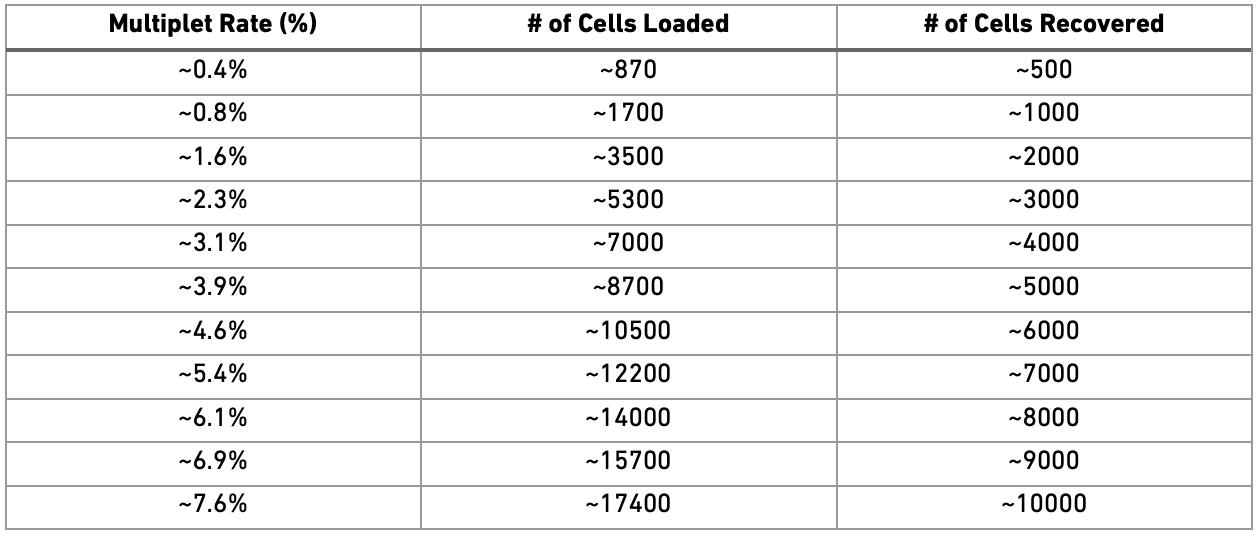

The data we are using contained about 10000 cells per sample (as in the
knee plot at the beginning), hence we can assume that it originates from
around 18000 loaded cells and should have a doublet rate at about 7.6%.

> **Warning**
>
> Doublet prediction, like the rest of the filtering, **should be run on
> each sample separately**.

Here, we apply `DoubletFinder` to predict doublet cells. Most parameters
are quite standard, we mostly need to choose `nExp` (expected number of
doublets), `PCs` (number of principal components to use), `sct` (use the
normalized data). The last three option are not part of the package, but
have been added by creating a slightly modified version
([here](https://github.com/SamueleSoraggi/DoubletFinder)) - they allow
to use multiple cores and a subset of cells for calculations for a
considerable speedup. However, the code takes some time to run, so be
patient. There will be a lot of printout as well, but don’t worry.

In [ ]:
nExp <- round(ncol(Control1_seurat_norm) * 0.076)  # expected doublet rate

In [ ]:
Control1_seurat_norm <- doubletFinder_v3(Control1_seurat_norm,
                                                  pN = 0.25, #proportion of doublets to simulate)
                                                  pK = 0.09, 
                                                  nExp = nExp, 
                                                  PCs = 1:15, 
                                                  sct=TRUE, 
                                                  workers=8, 
                                                  future.globals.maxSize = 8*1024^13,
                                                  seurat.ncells=3000)

We visualize the UMAP plot and which cells are estimated doublets in
[Figure 18](#fig-doublets). Fortunately, there are only a few potential
doublets.

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)

DF.name = colnames(Control1_seurat_norm@meta.data)[grepl("DF.classification", colnames(Control1_seurat_norm@meta.data))]

DimPlot(Control1_seurat_norm, group.by = DF.name, pt.size = 2, 
        split.by = DF.name)

Sometimes doublets have more detected genes than a single cell. In our
case, some of the droplets have higher number of genes than the average
(the red violin is large also above 3000 detected genes), so there is
aclear sign of the presence of some doublets. Of course, as with any
filtering, we might remove some actual cells. To be more effective in
our filtering, we can select doublets with more than 2000 detected genes
when we filter.

In [ ]:
VlnPlot(Control1_seurat_norm, features = "nFeature_RNA", group.by = DF.name, pt.size = 0.1)

Here we keep only singlets:

In [ ]:
Control1_seurat_norm = Control1_seurat_norm[, (Control1_seurat_norm@meta.data[, DF.name] == "Singlet")&(Control1_seurat_norm@meta.data$nFeature_RNA>2000)]

We save our data after all the filtering work!

In [ ]:
SaveH5Seurat(object = Control1_seurat_norm, 
             filename = "control1.normalized.h5Seurat", 
             overwrite = TRUE,
             verbose = FALSE)

# Integration

Integration of scRNA-seq data is useful to combine datasets from
different experimental conditions (in our case the Control vs Infected)
and sequencing runs, to gain a broader understanding of cellular
processes. Integration is challenging due to technical variations and
biological differences between the datasets (where we want to remove the
formers to study correctly the latters).

Before integrating scRNA-seq datasets, we have applyed **quality control
and normalization to each sample** to ensure consistency and accuracy of
the data. Integration can happen using various methods (Adossa et al.
(2021)). Seurat uses **canonical correlation analysis (CCA)** (Stuart et
al. (2019), Xinming (2022)) to integrate scRNA-seq datasets from
different experimental conditions. CCA identifies shared variation
between two datasets while accounting for technical differences, such as
batch effects.

The shared covariance patterns **can represent biological signals that
are common across the datasets**, such as cell types or signaling
pathways.

We load another control and two infected datasets. Those have been
previously preprocessed, so you will not need to. Remember again: each
dataset must be preprocessed separately before integration.

In [ ]:
Control1_seurat_norm <- LoadH5Seurat("control1.normalized.h5Seurat", verbose = FALSE)

In [ ]:
Control2_seurat_norm <- LoadH5Seurat("../Data/control2.normalized.h5Seurat", verbose = FALSE)
Infected1_seurat_norm <- LoadH5Seurat("../Data/infected1.normalized.h5Seurat", verbose = FALSE)
Infected2_seurat_norm <- LoadH5Seurat("../Data/infected2.normalized.h5Seurat", verbose = FALSE)

To integrate the datasets, we need to start creating a list with all
datasets.

In [ ]:
Gifu.list <- list(Control1_seurat_norm, 
                  Control2_seurat_norm, 
                  Infected1_seurat_norm, 
                  Infected2_seurat_norm)

We then start by normalizing each dataset of the list with
`SCtransform`.

In [ ]:
Gifu.list <- lapply(X = Gifu.list, FUN = function(x) {
  message("Normalizing\n")
  x <- SCTransform(x, ncells=3000, variable.features.n = 2000, return.only.var.genes = FALSE, verbose=FALSE)
})

> **Note**
>
> Running `SCTransform` as above does not contain any variable to
> regress out. By definition, the normalization will remove the
> technical effect of the number of transcripts per cell only. This is
> important because the amount of transcripts greatly vary in each cell,
> and it might seem a sign of biological variation, rather than a sign
> of varying capture efficiency of the mRNA transcripts. If you want to
> remove other sources of technical variation, for example chloroplastic
> and mitochondrial transcripts percentage, then you can use this
> command
>
>     x <- SCTransform(x, vars.to.regress = c("percent.mt",  "percent.chloroplast"),
>                      variable.features.n = 10000,
>                      return.only.var.genes = FALSE,
>                      verbose = TRUE)
>
> You can also include differences due to biological variation which you
> want to remove, to highlight the effect of other biological processes.
> Find the [manual of
> SCTransform](https://satijalab.org/seurat/reference/sctransform) to
> understand all possible options of the command. [This other
> tutorial](https://hbctraining.github.io/scRNA-seq/lessons/06_SC_SCT_and_integration.html)
> has a good application of `SCTransform` which you can read.

Now we apply the CCA (Canonical Correlation Analysis) to put datasets
together according to their similarities, while removing differences.
The number of genes to use during integration is expressed below as
`nfeatures`. The default choice is 2000 as written below.

In [ ]:
Gifu.features <- SelectIntegrationFeatures(object.list = Gifu.list, nfeatures = 2000)

Gifu.list <- PrepSCTIntegration(object.list = Gifu.list, anchor.features = Gifu.features)

In [ ]:
Gifu.anchors <- FindIntegrationAnchors(object.list = Gifu.list, normalization.method = "SCT", 
                                       anchor.features = Gifu.features, reference = c(1,2))

seurat.integrated <- IntegrateData(anchorset = Gifu.anchors, normalization.method = "SCT")

Now the default assay used for analysis has changed into `integrated`:

In [ ]:
cat("The default assay of the data is now called: ")
cat(DefaultAssay(seurat.integrated))

We need to recalculate PCA and UMAP to look at all datasets integrated
together. We choose again 10 principal components from
[Figure 19](#fig-elbowint). The newUMAP is in [Figure 20](#fig-umapint).

In [ ]:
seurat.integrated <- RunPCA(object = seurat.integrated, verbose = FALSE)

In [ ]:
ElbowPlot(seurat.integrated, ndims = 30)

In [ ]:
seurat.integrated <- FindNeighbors(object = seurat.integrated, dims = 1:20, k.param = 30)

In [ ]:
seurat.integrated <- RunUMAP(object = seurat.integrated, dims = 1:20, a=.8, b=.8)

In [ ]:
seurat.integrated <- SetIdent(seurat.integrated, value = "orig.ident")

In [ ]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(object = seurat.integrated, reduction = "umap",  label = T, repel = TRUE, pt.size = 0.5)

We save our integrated data

In [ ]:
SaveH5Seurat(object = seurat.integrated, filename = "seurat.integrated.h5Seurat", overwrite=TRUE)

## Clustering and cell type assignment

We perform clustering on the data using the leiden algorithm
(blondel_fast_2008, Traag, Waltman, and Van Eck (2019)). Then, we look
at a typical strategy of **naming clusters by visualizing known
markers**. Since this is very subjective and biased, we then resort to
naming cell types **using a reference annotated dataset**. An overview
of cell type assignment procedures can be found at Cheng et al. (2023).

In [ ]:
seurat.integrated <-  LoadH5Seurat("seurat.integrated.h5Seurat", verbose=FALSE)

Clustering function `FindClusters`. The resolution is used to change the
number of clusters detected. We do not need many, so we set on to 0.5.
Usual values range between 0.1 and 1.

In [ ]:
seurat.integrated <- FindClusters(object = seurat.integrated, 
                                  resolution = .5,
                                  random.seed = 123)

The clusters are saved in the meta data table as
`integrated_snn_res.0.25`. **Note that the name changes with the
resolution**. Also observe how much metadata we have: many columns come
from tools we have applied, such as doubletfinder (DF) and nearest
neighbor distances (snn).

In [ ]:
head( seurat.integrated@meta.data )

We can plot the clusters in the UMAP plot

In [ ]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(object = seurat.integrated, reduction = "umap",  label = T, repel = TRUE, pt.size = 0.5)

### Cluster assignment from visualized marker scores

Here, we look at how to assign names based on known markers. In this
procedure, biological knowledge of the cell types is needed. Below,
there is a list of known markers for each cell type, extracted from the
supplementary data of Frank et al. (2023).

In [ ]:
features_list <- list(
    'Cortex_scoring' = c("LotjaGi1g1v0006200",
                 "LotjaGi1g1v0022100",
                 "LotjaGi1g1v0261700",
                 "LotjaGi1g1v0348000",
                 "LotjaGi2g1v0303000",
                 "LotjaGi3g1v0505900"),
    'Epidermis_scoring' = c("LotjaGi1g1v0080000",
                    "LotjaGi1g1v0377600",
                    "LotjaGi1g1v0613100",
                    "LotjaGi3g1v0070500"),
    'Endodermis_scoring' = c("LotjaGi1g1v0114400",
                     "LotjaGi1g1v0221300",
                     "LotjaGi1g1v0240900-LC",
                     "LotjaGi1g1v0707500"), 
    'RootCap_scoring' = c("LotjaGi1g1v0020900",
                   "LotjaGi1g1v0039700-LC",
                   "LotjaGi1g1v0040300",
                   "LotjaGi1g1v0147500"),  
    'Meristem_scoring'= c("LotjaGi4g1v0300900",
                         "LotjaGi6g1v0056500",
                         "LotjaGi1g1v0594200"),
    'Phloem_scoring'= c("LotjaGi1g1v0028800",
                "LotjaGi1g1v0085900",
                "LotjaGi1g1v0119300",
                "LotjaGi1g1v0149100"),
    'QuiescentCenter_scoring' = c("LotjaGi1g1v0004300",
                           "LotjaGi1g1v0021400",
                           "LotjaGi1g1v0052700",
                           "LotjaGi1g1v0084000"),
    'RootHair_scoring'= c("LotjaGi1g1v0014300",
                   "LotjaGi1g1v0109000",
                   "LotjaGi1g1v0109100",
                   "LLotjaGi1g1v0143900"),  
    'Pericycle_scoring'= c("LotjaGi3g1v0222100",
                   "LotjaGi3g1v0395900-LC",
                   "LotjaGi5g1v0166000-LC",
                   "LotjaGi3g1v0395500-LC",
                   "LotjaGi1g1v0783700-LC",
                   "LotjaGi2g1v0333200",
                   "LotjaGi4g1v0293000-LC"),     
    'Stele_scoring' = c("LotjaGi2g1v0126700",
                "LotjaGi1g1v0558200",
                "LotjaGi4g1v0215500",
                "LotjaGi3g1v0174100",
                "LotjaGi5g1v0288600",
                "LotjaGi3g1v0129700"),
    'Xylem_scoring' = c("LotjaGi1g1v0623100",
                "LotjaGi1g1v0569300",
                "LotjaGi1g1v0443000",
                "LotjaGi1g1v0428800")
    )

Here, we need a function calculating the scores for each cell type. This
is the average expression of the markers in the list, from which we
remove the average expression of some control genes, which are supposed
not to be specific for the cell type of interest. The cells matching the
desired type should retain a high score.

In [ ]:
seurat.clustered <- AddModuleScore(
  object = seurat.integrated,
  features = features_list,
  ctrl = 5,
  name = 'LJ_scores'
)

We also apply a function (from `script.R`) to rename the scores in the
metadata. Their names are not intuitive by default, they are all called
with the name chosen above and a number after it:

In [ ]:
names(seurat.clustered@meta.data)

In [ ]:
seurat.clustered <- renameScores(markers_list = features_list, seurat_data = seurat.clustered)      

Now we run the function `plotScoresUMAP` (from the file `script.R`). In
[Figure 22](#fig-scores) we can see that some clusters are easy to
classify (phloem and xylem), but many others are not. This is mainly due
to the fact that the change of many cell types is a continuum, and this
manual annotation is very subjective.

In [ ]:
plotScoresUMAP(markers_list = features_list, seurat_data = seurat.clustered)                                  

One easy solution is to use the highest scoring of each cluster to
assign the cluster name. Below, in the function `clusterNames`, for each
cluster, we sum the scores of each cell type, and the highest value
decides the cluster name.

In [ ]:
#use the clustering above
Idents(seurat.clustered) <- 'integrated_snn_res.0.5' 
#assign names
seurat.clustered@meta.data["Cell_types"] <- clusterNames(seurat.clustered, features_list)
#use the new names as clustering labels
Idents(seurat.clustered) <- 'Cell_types'

> **Manual assignment**
>
> If you wanted to manually assign cell types, then you could use the
> command `RenameIdents`, for example
>
>     Idents(seurat.clustered) <- 'integrated_snn_res.0.5'
>
>     seurat.clustered <- RenameIdents(object = seurat.clustered,
>                                    "2"="Cortex", "5"="Cortex", "11"="Cortex",
>                                    "6"="Epidermis", "12"="Epidermis", "7"="Epidermis",
>                                    "15"="Endodermis",  
>                                    "0"="Root_Cap", "13"="Root_Cap",
>                                    "16"="Meristem",  
>                                    "17"="Phloem",
>                                    "10"="Root_Hair", "9"="Root_Hair",
>                                    "1"="PericycleStele", 
>                                    "3"="Pericycle", "19"="Pericycle",
>                                    "20"="Xylem")
>
> (the names do not match correctly the numbers of our clustering, they
> are just for the sake of the example)

It seems from [Figure 23](#fig-umapbyeye) that we have quite consistent
clustering across the various cell types.

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(object = seurat.clustered, reduction = "umap", repel = TRUE, label=T, pt.size = 2, label.size = 5)

#### Optional: assigning a mixed cluster

Consider the marker plots for pericycle and Stele cell types in
[Figure 22](#fig-scores). Here you can see overlap of the markers, which
is not unnormal, since biological processes often transition gradually
and eventually share some markers. We can try to separate the two cell
types more precisely by assigning the cell type to each single data
point, by comparing its score for Pericycle and Stele, instead of
renaming each cluster as a whole.

The code below runs such comparison for each cell in the pericycle and
stele clusters.

In [ ]:
peri <- seurat.clustered@meta.data$Pericycle_scoring[ seurat.clustered@meta.data$Cell_types == 'Pericycle' | seurat.clustered@meta.data$Cell_types == 'Stele']
stel <- seurat.clustered@meta.data$Stele_scoring[ seurat.clustered@meta.data$Cell_types == 'Pericycle' | seurat.clustered@meta.data$Cell_types == 'Stele' ]
peri_stele <- peri>=stel
finalcl = c()
for(i in peri_stele)
    finalcl = c(finalcl, ifelse(i, "Pericycle", "Stele"))

celltypes <- seurat.clustered@meta.data$Cell_types
celltypes[ seurat.clustered@meta.data$Cell_types == 'Pericycle' | seurat.clustered@meta.data$Cell_types == 'Stele' ] <- finalcl
seurat.clustered@meta.data$Cell_types <- celltypes
Idents(seurat.clustered) <- 'Cell_types'

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(object = seurat.clustered, reduction = "umap", repel = TRUE, label=T, pt.size = 2, label.size = 5)

### Cluster assignment from an annotated dataset

We now use the annotated data from Frank et al. (2023) (which is the
same we are using in the tutorial) to transfer data labels to our own
processed data. More about label transfer can be read at Stuart et al.
(2019). We load the data from the paper and define reference and query
data.

In [ ]:
seurat.reference <- readRDS("../Data/data_lavinia.RDS")

In [ ]:
seurat.query <- seurat.clustered

We have to define the data integration between query and reference
before we can transfer the cluster names. For the algorithm to work, we
need to use the “RNA” assay, which contains raw expression values.

In [ ]:
DefaultAssay(seurat.query) <- "RNA"

In [ ]:
lotusjaponicus.anchors <- FindTransferAnchors(reference = seurat.reference, 
                                        features = intersect( rownames(seurat.query), 
                                                   rownames( seurat.reference[['SCT']]@scale.data ) ),
                                        query = seurat.query, dims = 1:20, 
                                        reference.reduction = "pca",
                                        reference.assay='RNA')

Calculating the integration of the labels from the reference takes time.
So we save the calculated anchors for the integration. If you need to
rerun the code, skip the command above and instead load the data with
`readRDS` below.

In [ ]:
saveRDS(lotusjaponicus.anchors, file = "anchors.RDS")

In [ ]:
lotusjaponicus.anchors <- readRDS("anchors.RDS")

Now it is finally time to transfer the labels and add them to the
metadata. The column in the metadata is called by default
`predicted.id`.

In [ ]:
predictions <- TransferData(anchorset = lotusjaponicus.anchors, 
                            refdata = Idents(seurat.reference), 
                            dims = 1:20)

In [ ]:
seurat.clustered <- AddMetaData(seurat.clustered, metadata = predictions['predicted.id'])

Just as a reminder of what is in the metadata, we can quickly look at
the column names. Those are ordered by when we added things along the
analysis. If you read the names, you can recognize part of the analysis
steps until now.

In [ ]:
names( seurat.clustered@meta.data )

Here we define as clustering for the data and the plots, the one
transfered just before. We then have a look at
[Figure 25](#fig-transfer) to observe that the labels look fine.

In [ ]:
Idents(seurat.clustered) <- 'predicted.id'

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(object = seurat.clustered, 
        reduction = "umap", 
        repel = TRUE, label=T, 
        pt.size = 0.5, label.size = 10, )

We save the data

In [ ]:
SaveH5Seurat(object = seurat.clustered, 
             filename = "seurat.clustered.h5Seurat", 
             overwrite = TRUE,
             verbose=FALSE)

# Gene Expression Analysis

In this section we explore the gene expression through

-   determining **differentially expressed genes** for the infected
    condition against the control. Differentially expressed genes are
    significantly more epressed in one of the two groups used for the
    comparison. Usually the wild type is used as query for the
    comparison, such that differentially expressed genes are referred to
    the perturbated condition (infection, knock-out, illness, …)
-   studying **coexpression modules** (a module is a group of gene
    similarly expressed across cells in the data) to find if
    -   any of them contains the gene of interest,
    -   they are significantly more expressed in specific cell groups
        (**Differential module expression**)
    -   if there are specific known functions associated to some modules

We will also use gene ontology terms for understanding the function of
groups of genes.

## Differential Gene Expression (DGE)

Here we test each cluster to see which are significantly more expressed
genes in the infected samples compared to the wild-type samples. We also
see if we find the gene RINRK1 as being significant. Again, the
resulting genes can be useful to be integrated with the GO terms as we
did before.

We first have a quick look to see how much the RINRK1 gene is expressed
in the data. We use the `RNA` assay to plot the true expression values.
The UMAP plot shows few cells expressing the genes, meaning its average
expression is going to be very low, so it is likely we will not find the
gene to be differentially expressed anywhere.

In [ ]:
RINRK1.id <- 'LotjaGi1g1v0182900'

DefaultAssay(seurat.clustered) <- "RNA"

FeaturePlot(seurat.clustered,
            reduction = "umap", 
            features = c(RINRK1.id), 
            order = TRUE,
            min.cutoff = 0, 
            pt.size = 1,
            label = TRUE,
            label.size = 7) + theme(legend.position = "right")

From biological knowledge, we expect the gene mostly expressed in the
cortex and trichoblasts upon inoculation with rhizobia, and that is what
happens in our data as well. We can see it in the code and violin plot
of [Figure 27](#fig-vln)

In [ ]:
cat("Cells in inoculated L.J. expressing", RINRK1.id, "\n")

cat( sum( as.numeric(GetAssayData(seurat.clustered[RINRK1.id,]))>0 & 
     seurat.clustered@meta.data$Condition=="R7A" ) )

cat("\nCells in control L.J. expressing", RINRK1.id, "\n")

cat( sum( as.numeric(GetAssayData(seurat.clustered[RINRK1.id,]))>0 & 
    seurat.clustered@meta.data$Condition=="Control" ) )

In [ ]:
VlnPlot(seurat.clustered, 
        features = RINRK1.id)

The code below uses `FindMarkers` to compare `R7A` condition against
`Control` for each cluster, with a filter to remove non-singnificant
genes (keeping p-value below 0.001 and log fold change \> 1 and \< -1).
We keep also genes expressed 30% more than in the condition where they
are underexpressed. We use only the 2000 most variable genes, since we
are interested in very variable gene expressions across data.

In [ ]:
seurat.clustered <- FindVariableFeatures(seurat.clustered, nfeatures = 2000, assay = "integrated")

In [ ]:
DEG_table <- FindMarkers(seurat.clustered, 
                             assay='integrated',
                             ident.1 = "R7A",
                             ident.2 = "Control", 
                             group.by = "Condition",
                             subset.ident="Cortex",
                             min.diff.pct = 0.3,
                             verbose = TRUE, 
                             features = seurat.clustered@assays$integrated@var.features,
                             test.use = "wilcox") %>%
                             filter(p_val_adj <= 0.001 & abs(avg_log2FC)>1) %>%
                             select(-p_val)

In [ ]:
DefaultAssay(seurat.clustered) <- "integrated" #return to the integrated data
DEG <- data.frame()
cluster.names <- unique(Idents(seurat.clustered))

for(CLUSTER in cluster.names){
    DEG_table <- FindMarkers(seurat.clustered,
                             assay='integrated',
                             ident.1 = "R7A",
                             ident.2 = "Control", 
                             group.by = "Condition",
                             subset.ident=CLUSTER,
                             verbose = TRUE, 
                             min.diff.pct = 0.3,
                             features = seurat.clustered@assays$integrated@var.features,
                             test.use = "wilcox") %>%
                             filter(p_val_adj <= 0.001 & abs(avg_log2FC)>1) %>%
                             select(-p_val)
    if(dim(DEG_table)[1]>0){
        DEG_table$'cluster' <- CLUSTER
        DEG <- rbind(DEG, DEG_table)}
    else{
        message(paste0("---> Warning: No DE genes in cluster ", CLUSTER), appendLF=FALSE)}
    message(paste0("Done with cluster ",CLUSTER), appendLF=FALSE)
    }

DEG <- as.data.frame(DEG)
DEG$gene <- rownames(DEG)

The table looks like this. Columns represent:

-   average logfoldchange between R7A and Control
-   percentage of cells in R7A expressing the gene
-   percentage of cells in Control expressing the gene
-   adjusted p-value
-   cluster
-   gene

There are some genes in the table

In [ ]:
dim(DEG)[1]

We now integrate GO terms using a table of predefined GO terms. The
function doing that is `addGOterms`:

In [ ]:
go_table <- read.table("../Data/LJ_GO_terms.gaf", skip=6, sep='\t', fill=TRUE, quote = "\"")

In [ ]:
DEG <- addGOterms(DEG, go_table, n.cores = 16)

So we can see which GO terms are relevant in each cluster for the
infected samples against the control:

In [ ]:
DEG %>% filter(cluster=="Cortex" & GO!="Undefined")

Finally, we do not expect to find the RINRK1 gene as differentially
expressed, because its expression is on average too low.

In [ ]:
DEG %>% filter(gene==RINRK1.id)

We can save the table for future use. Such a table can be downloaded and
open in any table processor (such as Excel).

In [ ]:
write.csv(DEG_table, "DEG_table.csv")

## Coexpression analysis

We use the package hdWGCNA to detect groups of cells expressed
simultaneously, and we find which modules are differentially expressed
in specific clusters. We look at the GO terms to gain biological insight
in the data.

> **Note**
>
> Before running hdWGCNA, we first have to set up the Seurat object.
> Most of the information computed by hdWGCNA will be stored in the
> Seurat object’s `@misc` slot.

Here we will set up the Seurat object using the `SetupForWGCNA`
function, specifying the name of the `hdWGNCA` experiment. This function
also selects the genes that will be used for WGCNA. The user can select
genes using three different approaches using the posse gene_select
parameter:

-   variable: use the genes stored in the Seurat object’s
    VariableFeatures.
-   fraction: use genes that are expressed in a certain fraction of
    cells for in the whole dataset or in each group of cells, specified
    by `group.by`.
-   custom: use genes that are specified in a custom list.

In this example, we will select genes that are expressed in at least 5%
of cells in this dataset, and we will name our `hdWGCNA` experiment
“tutorial”.

In [ ]:
seurat.clustered <- LoadH5Seurat("seurat.clustered.h5Seurat", verbose=FALSE)

In [ ]:
seurat.clustered <- SetupForWGCNA(
  seurat.clustered,
  gene_select = "variable",
  fraction = 0.05, # fraction of cells that a gene needs to be expressed in order to be included
  wgcna_name = "tutorial" # the name of the hdWGCNA experiment
)

### Construct metacells

After we have set up our Seurat object, the first step in running the
hdWGCNA pipeline is to construct metacells from the single-cell dataset.
Briefly, metacells are **aggregates of small groups of similar cells
originating from the same biological sample of origin**.

![Workflow of hdWGCNA. Similar cells are summed or averaged together to
form metacells. The resulting matrix is then used as the basis for
inferring modules of coexpressed genes. The metacells expression matrix
is the base for all the downstream analysis, such as differential
expression of genes modules in specific
clusters](attachment:./images/hdwgcna.jpg) {#fig-hdwgcna, width=800}

> **Something more about hdWGCNA**
>
> The k-Nearest Neighbors (KNN) algorithm is used to identify groups of
> similar cells to aggregate, and then the average or summed expression
> of these cells is computed, thus yielding a metacell gene expression
> matrix (**as if you had many bulk samples**). The **sparsity of the
> metacell expression matrix is considerably reduced** when compared to
> the original expression matrix, and therefore it is preferable to use.
> We were originally motivated to use metacells in place of the original
> single cells because correlation **network approaches such as WGCNA
> are sensitive to data sparsity**.
>
> `hdWGCNA` includes a function `MetacellsByGroups` to construct
> metacell expression matrices given a single-cell dataset. This
> function constructs a new Seurat object for the metacell dataset which
> is stored internally in the `hdWGCNA` experiment. The `group.by`
> parameter determines which groups metacells will be constructed in. We
> only want to construct metacells from cells that came from the same
> biological sample of origin, so it is critical to pass that
> information to `hdWGCNA` via the `group.by` parameter. Additionally,
> we usually construct metacells for each cell type separately. Thus, in
> this example, we are **grouping by Sample and cell type** to achieve
> the desired result.
>
> **The number of cells to be aggregated `k` should be tuned based on
> the size of the input dataset**, in general a lower number for `k` can
> be used for small datasets. We generally use `k` values between 20 and
> 75. The dataset used for this tutorial has 21,369 cells, and here we
> use `k=30`. The amount of allowable overlap between metacells can be
> tuned using the `max_shared` argument. There should be a range of `k`
> values that are suitable for reducing the sparsity while retaining
> cellular heterogeneity for a given dataset, rather than a single
> optimal value.
>
> Note: the authors of `hdWGCNA` have found that the metacell
> aggregation approach does not yield good results for extremely
> underrepresented cell types. For example, in this dataset, the
> `Meristem` and `Xylem` are the least represented, and will be excluded
> them from this analysis. `MetacellsByGroups` has a parameter
> `min_cells` to exclude groups that are smaller than a specified number
> of cells. **Errors are likely to arise if the selected value for
> `min_cells` is too low**.

Here **we construct metacells and normalize the resulting expression
matrix** using the following code (read the additional text in the box
above to understand the parameters). Note how the clusters Xylem and
Quiescent center are removed, simply because they contain too few cells
and cannot be used. So from now on we do not consider them for the
coexpression analysis. Note that we use the scaled integrated data
matrix (assay `integrated` and slot `scale.data`), so that we take
advantage of the integration procedure we have been running before to
unbias the data from technical features.
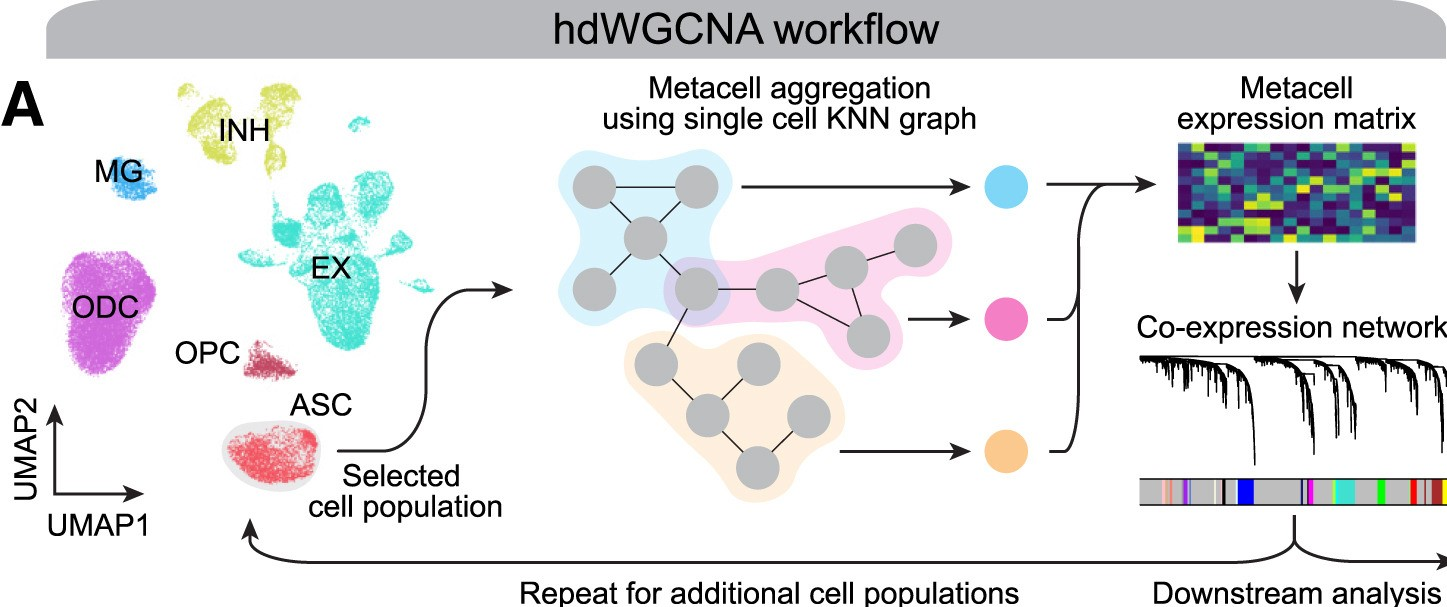

In [ ]:
# construct metacells  in each group
seurat.clustered <- MetacellsByGroups(
  seurat_obj = seurat.clustered,
  group.by = c("predicted.id", "Condition"), # specify metadata to split by cluster and condition
  reduction = 'pca', # select the dimensionality reduction to perform KNN on
  k = 30, # nearest-neighbors parameter
  max_shared = 10, # maximum number of shared cells between two metacells
  ident.group = 'predicted.id', # set the Idents of the metacell seurat object
  assay = "integrated",
  slot = "scale.data",
  min_cells = 100,
  wgcna_name = "tutorial",
  verbose=TRUE
)

The metacell matrix always needs to be normalized, which is immediately
done below

In [ ]:
#normalize metacell expression matrix:
seurat.clustered <- NormalizeMetacells(seurat.clustered)

Here we specify the expression matrix that we will use for network
analysis. It is natural to choose the integrated data matrix (which is
chosen with the assay `integrated` and the matrix slot `counts`). We
still need the data matrix after building the gene coexpression network
when we want to evaluate the expression of each cell and gene in the
original data.

In [ ]:
seurat.clustered <- SetDatExpr(
  seurat.clustered,
  group_name = c('Pericycle','Cortex','Trichoblasts','Root tip',
                 'Phloem','Stele','Endodermis','Atrichoblasts',
                 'Meristem'), #all groups of interest in the data (we use all clusters)
  group.by='predicted.id', # the metadata column containing the cell type info. This same column should have also been used in MetacellsByGroups
  assay = 'integrated', # using integrated assay
  slot = 'counts' # using count data
)

### Select soft-power threshold

Next we will select the soft power threshold. This is an extremely
important step in the pipeline. `hdWGCNA` constructs a gene-gene
correlation adjacency matrix to infer co-expression relationships
between genes. The correlations are **raised to a power to reduce the
amount of noise present in the correlation matrix**, thereby **retaining
the strong connections and removing the weak connections**. Therefore,
it is critical to determine a proper value for the soft power threshold.

We use the function `TestSoftPowers` to perform a parameter sweep for
different soft power thresholds. This function helps us to guide our
choice in a soft power threshold for constructing the co-expression
network by inspecting the resulting network topology for different power
values. The following code performs the parameter sweep and outputs a
summary figure.

In [ ]:
# Test different soft powers:
seurat.clustered <- TestSoftPowers(powers = 1:50,
  seurat.clustered,
  networkType = 'signed'
)

# plot the results:
plot_list <- PlotSoftPowers(seurat.clustered)

# assemble with patchwork
wrap_plots(plot_list, ncol=2)

The general guidance for `hdWGCNA` is to pick the lowest soft power
threshold that has Model Fit greater than or equal to 0.8. We will do it
automatically, so you do not need to do it manually following the
illustration fo [Figure 28](#fig-sweep).

## Construction of co-expression network

We now have everything that we need to construct our co-expression
network. Here we use the `hdWGCNA` function `ConstructNetwork`. This
function has quite a few parameters to play with if you are an advanced
user (read [this
manual](https://rdrr.io/github/smorabit/hdWGCNA/man/ConstructNetwork.html)
and the function `ConstructNetwork` is based on
[here](https://www.rdocumentation.org/packages/WGCNA/versions/1.72-5/topics/blockwiseConsensusModules)),
but we use default parameters that work well with many single-cell
datasets.

The following code selects the power threshold from the values plotted
in [Figure 28](#fig-sweep) and constructs the co-expression network.

In [ ]:
# automatic choice of soft power value
softPowerValue <- which(seurat.clustered@misc$tutorial$wgcna_powerTable$SFT.R.sq > .8)[1]
message(paste0("Chosen Soft Power Value: ",softPowerValue))

#multithreading for faster calculations
enableWGCNAThreads(nThreads = 8)

# construct co-expression network
seurat.clustered <- ConstructNetwork(na.rm=TRUE,
  seurat.clustered,
  soft_power=softPowerValue,                                   
  setDatExpr=FALSE,
  tom_name = 'Network', # name of the topoligical overlap matrix written to disk
  overwrite_tom = TRUE,
  randomSeed = 123
)

We can plot the network dendrogram in [Figure 29](#fig-dendro). Each
leaf on the dendrogram represents a single gene, and the color at the
bottom indicates the co-expression module assignment. Clusters with
similar brancing heights contain genes that are more similar to each
other in terms of expression patterns when compared to genes in clusters
with higher variation in merging heights.

> **Note**
>
> the “gray” module consists of genes that were not grouped into any
> co-expression module. The gray module is to be ignored for all
> downstream analysis and interpretation.\*\*

In [ ]:
PlotDendrogram(seurat.clustered, main='Phloem hdWGCNA Dendrogram')

### Module Eigengenes (MEs)

We calculate harmonized module eigengenes. This is a way of doing PCA of
the expression matrix of metacells including the genes of one
coexpression module at a time. Thus we have a PCA of the data for each
module. The first principal component of each PCA is called module
eigengene: it is enough to distinguish one module from all the others
and characterize the expression pattern of the module (Langfelder and
Horvath (2007))!

Dimensionality reduction techniques are a very hot topic in single-cell
genomics (Xiang et al. (2021)). It is well known that technical
artifacts can muddy the analysis of single-cell datasets, and over the
years there have been many methods that aim to reduce the effects of
these artifacts. Therefore it stands to reason that MEs would be subject
to these technical artifacts as well, and `hdWGCNA` seeks to alleviate
these effects by using the integration software `Harmony` (Korsunsky et
al. (2019)).

The following code performs the module eigengene computation harmonizing
by the Sample of origin using the `group.by.vars` parameter. We need to
run `ScaleData` to avoid errors from the `harmony` software.

In [ ]:
# need to run ScaleData first or else harmony throws an error:
seurat.clustered <- ScaleData(seurat.clustered, 
                              features=VariableFeatures(seurat.clustered), 
                              verbose = FALSE)

We still want to use the integrated data matrix to calculate the modules
eigengenes, so we assign the scaled matrix to the `counts` slot, which
is where `hdWGCNA` looks by default for computing module eigengenes.

In [ ]:
seurat.clustered@assays$integrated@counts <- seurat.clustered@assays$integrated@scale.data

In [ ]:
# compute all MEs in the full single-cell dataset
seurat.clustered <- ModuleEigengenes( 
 seurat.clustered,
 group.by.vars="orig.ident",
 verbose = FALSE
)

### Compute module connectivity

In co-expression network analysis, we often want to focus on the **hub
genes, those which are highly connected within each module**. Therefore
we wish to determine the eigengene-based connectivity, also known as
kME, of each gene. The `ModuleConnectivity` function computes the kMEs
in the single-cell dataset (rather than the metacell dataset). This
function essentially computes pairwise correlations between genes and
module eigengenes. kME can be computed for all cells in the dataset, but
it is recommended computing kMEs in the cell type(s) or group(s)
previously used to run `ConstructNetwork`.

In [ ]:
# compute eigengene-based connectivity (kME):
seurat.clustered <- ModuleConnectivity(
  seurat.clustered,
  group.by = 'predicted.id', 
  group_name = c('Pericycle','Cortex','Trichoblasts','Root tip',
                 'Phloem','Stele','Endodermis','Atrichoblasts',
                 'Meristem'),
)

For convenience, we re-name the hdWGCNA modules to indicate such that
they are not called `cluster##`, but `Lotus-Mod##` instead, which is a
more meaningful name.

In [ ]:
# rename the modules
seurat.clustered <- ResetModuleNames(
  seurat.clustered,
  new_name = "Lotus-Mod"
)

We can visualize the genes in each module ranked by kME using the
`PlotKMEs` function. Each plot shows the kME-score (which is at most 1)
for a module. On the left side of the y axis you see the kME scores (how
much a gene is well-correlated with others in the module). On the right
side of the y axis you have a bar showing how many genes have the
corresponding kME score. The x axis should show the number of genes
corresponding to the bar (but no number is shown by this plotting
function). What is important to observe is that only few genes have high
kME score in each module, and those are the ones you want to focus on.
The top ten names are plotted for each module as well.

In [ ]:
options(repr.plot.width=20, repr.plot.height=25)
p <- capture.output({PlotKMEs(seurat.clustered, ncol=3, text_size = 4);})

### Getting the module assignment table

The plots of [Figure 30](#fig-kme) are a bit hard to read, though fancy
to plot. `hdWGCNA` allows for easy access of the module assignment table
using the `GetModules` function. This table consists of three columns:
`gene_name` stores the gene’s symbol or ID, module stores the gene’s
module assignment, and color stores a color mapping for each module
(which is used in plotting steps). If `ModuleConnectivity` has been used
on this hdWGCNA experiment, as it is our case, this table has additional
columns with the connectivities plotted in [Figure 30](#fig-kme)

In [ ]:
# get the module assignment table:
modules <- GetModules(seurat.clustered)

# show the first 6 columns:
head(modules[,1:6])

A table of the top N hub genes sorted by kME can be extracted using the
`GetHubGenes` function. Here we choose the top 10 genes, but you can
change the value if you want. The table contains all the top 10 genes
for each module, the name of the module they come from and the kME
score.

In [ ]:
# get hub genes
hub_df <- GetHubGenes(seurat.clustered, n_hubs = 10)
# print the first lines of the table to see its structure
head( hub_df )

Again, we can assign GO terms to better check associated functions

In [ ]:
go_table <- read.table("../Data/LJ_GO_terms.gaf", skip=6, sep='\t', fill=TRUE, quote = "\"")

In [ ]:
hub_df <- addGOterms(input_table = hub_df, 
                     go_table = go_table, 
                     gene_column = 'gene_name',
                     n.cores = 16)

Now it is easy to look at each module and relevant GO terms.

In [ ]:
hub_filtered <- hub_df %>% filter(module == "Lotus-Mod3")

In [ ]:
hub_filtered

We save the table for later use

In [ ]:
write.csv(hub_df, "top_genes_networks.csv")

We can also plot the modules to see where they are most relevant on the
UMAP plot. First we calculate the scores of each module and renames each
module from `Cluster##` to `Lotus-Mod##`. The scores are the same for
the markers plots for clustering, but calculated instead on the genes of
each module.

In [ ]:
features_list <- list()

for(MOD in hub_df$module){
    genes <- hub_df %>% filter(module == MOD)
    genes_mod <- genes$gene_name
    features_list[[MOD]] <- genes_mod
    }

seurat.clustered <- AddModuleScore(
  object = seurat.clustered,
  features = features_list,
  ctrl = 5,
)

seurat.clustered <- renameScores(markers_list = features_list, seurat_data = seurat.clustered)
plotScoresUMAP(markers_list = features_list, seurat_data = seurat.clustered)


> **Tip**
>
> Plots can be hard to see when they are small. You can plot any module
> singularly. For example Mod1. You simply need to choose one of the
> elements from `feature_list` (below we chose `feature_list[1]` for
> `Lotus-Mod1`)

In [ ]:
plotScoresUMAP(markers_list = features_list[1], seurat_data = seurat.clustered)

We save the seurat object and the network separately (because for some
inscrutable error, `hdWGCNA` cannot load together with the Seurat object
when it is needed again).

In [ ]:
SaveH5Seurat(seurat.clustered, 'seurat.network.h5Seurat', overwrite = TRUE, verbose=FALSE)

In [ ]:
saveRDS(seurat.clustered@misc, "network_lotus.RDS")

## Differential module Expression (DME) analysis

Lastly, we can see which modules are most expressed in a specific
cluster against the others, in a similar way to differential gene
expression.

In [ ]:
seurat.network <- LoadH5Seurat('seurat.network.h5Seurat', misc=FALSE, verbose=FALSE)

In [ ]:
seurat.network@misc <- readRDS("network_lotus.RDS")

Here we discuss how to perform **DME testing between two different
groups**. We use the `hdWGCNA` function `FindDMEs`, which is similar to
the Seurat function FindMarkers. We use the Mann-Whitney U test, also
known as the Wilcoxon test, to compare two groups, but other tests can
be used at the user’s discretion with the `test.use` parameter.

We are interested in defining our two groups both by condition. We
filter DMEs by p-value and fold-change, so to remove non-significant
ones from the list.

In [ ]:
R7Agroup <- seurat.network@meta.data %>% subset(Condition == 'R7A') %>% rownames
WTgroup <- seurat.network@meta.data %>% subset(Condition == 'Control') %>% rownames

In [ ]:
DMEs <- FindDMEs(
  seurat.network,
  barcodes1 = R7Agroup,
  barcodes2 = WTgroup,
  test.use='wilcox',
  wgcna_name='tutorial'
) %>% filter(p_val_adj < 0.001 & abs(avg_log2FC)>1) %>% select(-p_val)


The resulting table below is very similar to the one for differential
gene expression. Now the p-values and fold changes are referred to the
differential module expression in the inoculated VS the control cells.
We can see there are some differences and one could study those modules
in depth by looking at the top genes and their GO terms.

In [ ]:
DMEs

Graphically, you can always produce a lollipop plot as in
[Figure 31](#fig-lol), where the size of each circle is the p-value, and
the x-axis is the log-fold change. A cross on a circle means the p-value
is not significant. In our case we filtered out p-values that were too
high, so we have only significant modules in the plot.

In [ ]:
options(repr.plot.width=6, repr.plot.height=6)

PlotDMEsLollipop(
  seurat.network, 
  DMEs, 
  wgcna_name='tutorial', 
  pvalue = "p_val_adj",
)

### One-versus-all DME analysis

This is another case of DME analysis, where each cluster is tested
against the rest of the data to see which modules are differentially
expressed and are specific of each cell type. We can test by cell type
(`predicted.id`) or by condition (`Condition`), or by any other label a
dataset might have and that is contained in the meta data.

In [ ]:
DMEs_all <- FindAllDMEs(
  seurat.network,
  group.by = 'predicted.id',
  wgcna_name = 'tutorial'
) 

The table is usually big, but you can choose to filter by various
parameters as below, and to look only at one cluster of interest

In [ ]:
DMEs_cortex <- DMEs_all %>% filter(p_val_adj < .001 & abs(avg_log2FC)>1 
                                       & is.finite(avg_log2FC)
                                       & group=='Cortex')

The DME analysis results in a lot of significant results for the cortex.
The most significant modules for a cluster are the ones where `pct.1`
and `pct.2` are very different, and at the same time have a large
fold-change and a small p-value. The column `group` tells you in which
cluster the module is differentially overexpressed (positive fold-change
`avg_log2FC`) or underexpressed (negative fold-change).

In [ ]:
DMEs_cortex

You can look at any other cluster. For example trichoblasts. Here you
can see how module 4 pops up as being basically entirely expressed only
in Trichoblasts.

In [ ]:
DMEs_tricho <- DMEs_all %>% filter(p_val_adj < .001 & abs(avg_log2FC)>1 
                                       & is.finite(avg_log2FC)
                                       & group=='Trichoblasts')

In [ ]:
DMEs_tricho

For better visualization, you can always use the lolliplot plots using
the correct table as an argument, so that you can plot multiple
instances for the various clusters. In [Figure 32](#fig-lol2) we plot
boyh for cortex and trichoblasts from the tables determined in the code
above.

In [ ]:
options(repr.plot.width=12, repr.plot.height=6)

#lollipop with cortex table
p1 <- PlotDMEsLollipop(
  seurat.network, 
  DMEs_cortex, 
  wgcna_name='tutorial', 
  pvalue = "p_val_adj",
)

#lollipop with trichoblasts table
p2 <- PlotDMEsLollipop(
  seurat.network, 
  DMEs_tricho, 
  wgcna_name='tutorial', 
  pvalue = "p_val_adj",
)

#plot an add a title
p1 + ggtitle("DMEs of Cortex VS data") + 
p2 + ggtitle("DMEs of Trichoblasts VS data")

> **Wrapping Up**
>
> This is the end of the tutorial. We have not shown much biological
> conclusion from the analysis - this is something that comes out by
> studying for example the GO terms of the various genes and modules
> identified. The scope of the tutorial was mainly to give all the means
> to perform your own analysis, from which you can then gain biological
> insight.
>
> If you are interested in more resources to learn single cell analysis,
> you can find them at some of our courses. We have other single-cell
> analysis tutorials including different tools at
>
> -   **Introduction to NGS data analysis** (found in the
>     `Genomics Sandbox` **[at this
>     link](https://cloud.sdu.dk/app/jobs/create?app=genomics&version=2023.03.01)** -
>     note that this is in the `python` language )
> -   **Introduction to scRNAseq analysis in R** (found in the
>     `Transcriptomics Sandbox` **[at this
>     link](https://cloud.sdu.dk/app/jobs/create?app=transcriptomics&version=2023.11)**
>     )
>
> You can also find a lot of material in the **[`Seurat`
> webpage](https://satijalab.org/seurat/articles/get_started.html)**. If
> you create a new notebook in this environment, you are likely to have
> all the packages needed to try the `Seurat` tutorials.

Adossa, Nigatu, Sofia Khan, Kalle T. Rytkönen, and Laura L. Elo. 2021.
“Computational Strategies for Single-Cell Multi-Omics Integration.”
*Computational and Structural Biotechnology Journal* 19: 2588–96.
<https://doi.org/10.1016/j.csbj.2021.04.060>.

Becht, Etienne, Leland McInnes, John Healy, Charles-Antoine Dutertre,
Immanuel W H Kwok, Lai Guan Ng, Florent Ginhoux, and Evan W Newell.
2019. “Dimensionality Reduction for Visualizing Single-Cell Data Using
UMAP.” *Nature Biotechnology* 37 (1): 38–44.
<https://doi.org/10.1038/nbt.4314>.

Cheng, Changde, Wenan Chen, Hongjian Jin, and Xiang Chen. 2023. “A
Review of Single-Cell RNA-Seq Annotation, Integration, and Cell–Cell
Communication.” *Cells* 12 (15): 1970.
<https://doi.org/10.3390/cells12151970>.

Fleming, Stephen J., Mark D. Chaffin, Alessandro Arduini, Amer-Denis
Akkad, Eric Banks, John C. Marioni, Anthony A. Philippakis, Patrick T.
Ellinor, and Mehrtash Babadi. 2023. “Unsupervised Removal of Systematic
Background Noise from Droplet-Based Single-Cell Experiments Using
CellBender.” *Nature Methods* 20 (9): 1323–35.
<https://doi.org/10.1038/s41592-023-01943-7>.

Frank, Manuel, Lavinia Ioana Fechete, Francesca Tedeschi, Marcin
Nadzieja, Malita Malou Malekzadeh Nørgaard, Jesus Montiel, Kasper
Røjkjær Andersen, Mikkel H. Schierup, Dugald Reid, and Stig Uggerhøj
Andersen. 2023. “Single-Cell Analysis Identifies Genes Facilitating
Rhizobium Infection in Lotus Japonicus.” *Nature Communications* 14
(November): 7171. <https://doi.org/10.1038/s41467-023-42911-1>.

Hafemeister, Christoph, and Rahul Satija. 2019. “Normalization and
Variance Stabilization of Single-Cell RNA-Seq Data Using Regularized
Negative Binomial Regression.” *Genome Biology* 20 (1): 296.
<https://doi.org/10.1186/s13059-019-1874-1>.

Heumos, Lukas, Anna C. Schaar, Christopher Lance, Anastasia
Litinetskaya, Felix Drost, Luke Zappia, Malte D. Lücken, et al. 2023.
“Best Practices for Single-Cell Analysis Across Modalities.” *Nature
Reviews Genetics* 24 (8): 550–72.
<https://doi.org/10.1038/s41576-023-00586-w>.

Korsunsky, Ilya, Nghia Millard, Jean Fan, Kamil Slowikowski, Fan Zhang,
Kevin Wei, Yuriy Baglaenko, Michael Brenner, Po-ru Loh, and Soumya
Raychaudhuri. 2019. “Fast, Sensitive and Accurate Integration of
Single-Cell Data with Harmony.” *Nature Methods* 16 (12): 1289–96.
<https://doi.org/10.1038/s41592-019-0619-0>.

Langfelder, Peter, and Steve Horvath. 2007. “Eigengene Networks for
Studying the Relationships Between Co-Expression Modules.” *BMC Systems
Biology* 1 (1): 54. <https://doi.org/10.1186/1752-0509-1-54>.

Li, Xiaolin, Zhiqiong Zheng, Xiangxiao Kong, Ji Xu, Liping Qiu, Jongho
Sun, Dugald Reid, et al. 2019. “Atypical Receptor Kinase RINRK1 Required
for Rhizobial Infection but Not Nodule Development in *Lotus
Japonicus*.” *Plant Physiology* 181 (2): 804–16.
<https://doi.org/10.1104/pp.19.00509>.

Luecken, Malte D, and Fabian J Theis. 2019. “Current Best Practices in
Single‐cell RNA‐seq Analysis: A Tutorial.” *Molecular Systems Biology*
15 (6): e8746. <https://doi.org/10.15252/msb.20188746>.

McGinnis, Christopher S., Lyndsay M. Murrow, and Zev J. Gartner. 2019.
“DoubletFinder: Doublet Detection in Single-Cell RNA Sequencing Data
Using Artificial Nearest Neighbors.” *Cell Systems* 8 (4): 329–337.e4.
<https://doi.org/10.1016/j.cels.2019.03.003>.

McInnes, Leland, John Healy, Nathaniel Saul, and Lukas Großberger. 2018.
“UMAP: Uniform Manifold Approximation and Projection.” *Journal of Open
Source Software* 3 (29): 861. <https://doi.org/10.21105/joss.00861>.

Morabito, Samuel, Fairlie Reese, Negin Rahimzadeh, Emily Miyoshi, and
Vivek Swarup. 2023. “<span class="nocase">hdWGCNA</span> Identifies
Co-Expression Networks in High-Dimensional Transcriptomics Data.” *Cell
Reports Methods* 3 (6): 100498.
<https://doi.org/10.1016/j.crmeth.2023.100498>.

Okamoto, Satoru, and Masayoshi Kawaguchi. 2015. “Shoot HAR1 Mediates
Nitrate Inhibition of Nodulation in *Lotus Japonicus*.” *Plant Signaling
& Behavior* 10 (5): e1000138.
<https://doi.org/10.1080/15592324.2014.1000138>.

Stuart, Tim, Andrew Butler, Paul Hoffman, Christoph Hafemeister,
Efthymia Papalexi, William M. Mauck, Yuhan Hao, Marlon Stoeckius, Peter
Smibert, and Rahul Satija. 2019. “Comprehensive Integration of
Single-Cell Data.” *Cell* 177 (7): 1888–1902.e21.
<https://doi.org/10.1016/j.cell.2019.05.031>.

Szczyglowski, Krzysztof, Robert S. Shaw, Judith Wopereis, Sue Copeland,
Dirk Hamburger, Beth Kasiborski, Frank B. Dazzo, and Frans J. De Bruijn.
1998. “Nodule Organogenesis and Symbiotic Mutants of the Model Legume
*Lotus Japonicus*.” *Molecular Plant-Microbe Interactions®* 11 (7):
684–97. <https://doi.org/10.1094/MPMI.1998.11.7.684>.

Traag, V. A., L. Waltman, and N. J. Van Eck. 2019. “From Louvain to
Leiden: Guaranteeing Well-Connected Communities.” *Scientific Reports* 9
(1): 5233. <https://doi.org/10.1038/s41598-019-41695-z>.

Wang, Qi, Jinge Liu, and Hongyan Zhu. 2018. “Genetic and Molecular
Mechanisms Underlying Symbiotic Specificity in Legume-Rhizobium
Interactions.” *Frontiers in Plant Science* 9.
<https://www.frontiersin.org/journals/plant-science/articles/10.3389/fpls.2018.00313>.

Xiang, Ruizhi, Wencan Wang, Lei Yang, Shiyuan Wang, Chaohan Xu, and
Xiaowen Chen. 2021. “A Comparison for Dimensionality Reduction Methods
of Single-Cell RNA-Seq Data.” *Frontiers in Genetics* 12 (March):
646936. <https://doi.org/10.3389/fgene.2021.646936>.

Xinming, Tu. 2022. “Seurat CCA? It’s Just a Simple Extension of PCA!”
<https://xinmingtu.cn/blog/2022/CCA_dual_PCA/>.

Young, Matthew D, and Sam Behjati. 2020. “SoupX Removes Ambient RNA
Contamination from Droplet-Based Single-Cell RNA Sequencing Data.”
*GigaScience* 9 (12): giaa151.
<https://doi.org/10.1093/gigascience/giaa151>.